###**0. Relevant Libraries**

* These are the libraries which I'll be using in this notebook.

* **For Installation**

In [1]:
try:
  import pyspark
except:
  %pip install pyspark
  import pyspark

try:
  import tensorflow
except:
  %pip install tensorflow
  import tensorflow

%pip install scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.3/317.3 MB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.2-py2.py3-none-any.whl size=317812365 sha256=45467904a5b166f7316bc88e4c34daafd6bf25cb005469bdd5b3d6d516081e25
  Stored in directory: /root/.cache/pip/wheels/34/34/bd/03944534c44b677cd5859f248090daa9fb27b3c8f8e5f49574
Successfully built pyspark


* **Standard Dependencies**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

* ***TensorFlow* Preprocessing Dependencies**

In [3]:
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

* ***TensorFlow* Model Dependencies**

In [4]:
from keras.models import Sequential
from keras.layers import Bidirectional, LSTM, Embedding, SpatialDropout1D, Dense
from keras.callbacks import EarlyStopping

* ***PySpark* Dependencies**

In [5]:
from pyspark import Row, SparkConf, SparkContext
import pyspark.sql.functions as f
from pyspark.sql import SQLContext, SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql.window import Window
from pyspark.sql.pandas.functions import pandas_udf
from pyspark.ml.feature import StringIndexer

* **Text Preprocessing Dependencies**

In [6]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
from string import punctuation
import re

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


###**1. PySpark Session**

* Starting our PySpark session

In [7]:
SPARK_CONF = SparkConf().set("spark.driver.host", "127.0.0.1")
SC         = SparkContext(conf = SPARK_CONF)
SPARK      = SparkSession.builder.getOrCreate()

SPARK

/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(


###**2. The Dataset**

* Loading our data using a *Spark* dataframe.
* This dataset is suitable for analysis using an RNN because it contains text data in the `PROD_DESC` column, which is sequential.
* RNNs are designed to handle sequential data by processing each word in a sentence and maintaining a hidden state that captures the context of the previous words.
* This allows the RNN to learn patterns and relationships between words in a sequence, making it effective for tasks such as text classification.
* Analyzing the product descriptions using an RNN could help identify key features or categories associated with different products.
* *Kaggle* link: https://www.kaggle.com/datasets/saurabhshahane/ecommerce-text-classification

In [8]:
DATA_URL = 'https://zenodo.org/records/3355823/files/ecommerceDataset.csv'
MY_DF    = SPARK.createDataFrame(pd.read_csv(DATA_URL, sep = ',', header = None))

MY_DF.show()

+---------+--------------------+
|        0|                   1|
+---------+--------------------+
|Household|Paper Plane Desig...|
|Household|SAF 'Floral' Fram...|
|Household|SAF 'UV Textured ...|
|Household|SAF Flower Print ...|
|Household|Incredible Gifts ...|
|Household|Pitaara Box Roman...|
|Household|Paper Plane Desig...|
|Household|Pitaara Box Roman...|
|Household|SAF 'Ganesh Moder...|
|Household|Paintings Villa U...|
|Household|Painting Mantra A...|
|Household|Paper Plane Desig...|
|Household|Pitaara Box Roman...|
|Household|Painting Mantra '...|
|Household|Indianara Motivat...|
|Household|Tamatina Fabric R...|
|Household|SAF Flower Print ...|
|Household|Posterhouzz Comic...|
|Household|ART DIOR | Set of...|
|Household|ART DIOR | Dancin...|
+---------+--------------------+
only showing top 20 rows



* **Check schema**

  * Checking our datatypes

In [9]:
MY_DF.printSchema()

root
 |-- 0: string (nullable = true)
 |-- 1: string (nullable = true)



###**3. Data Preprocessing**

* Firstly, I'll assign an *alias* to both columns.

In [10]:
MY_DF = MY_DF.select(MY_DF['1'].alias('PROD_DESC'), MY_DF['0'].alias('CATEGORY'))

MY_DF.show()

+--------------------+---------+
|           PROD_DESC| CATEGORY|
+--------------------+---------+
|Paper Plane Desig...|Household|
|SAF 'Floral' Fram...|Household|
|SAF 'UV Textured ...|Household|
|SAF Flower Print ...|Household|
|Incredible Gifts ...|Household|
|Pitaara Box Roman...|Household|
|Paper Plane Desig...|Household|
|Pitaara Box Roman...|Household|
|SAF 'Ganesh Moder...|Household|
|Paintings Villa U...|Household|
|Painting Mantra A...|Household|
|Paper Plane Desig...|Household|
|Pitaara Box Roman...|Household|
|Painting Mantra '...|Household|
|Indianara Motivat...|Household|
|Tamatina Fabric R...|Household|
|SAF Flower Print ...|Household|
|Posterhouzz Comic...|Household|
|ART DIOR | Set of...|Household|
|ART DIOR | Dancin...|Household|
+--------------------+---------+
only showing top 20 rows



* **Checking for Missing Values**

  * Ensure that there are no missing data values present.

In [11]:
MY_DF.select([count(when(isnull(C), C)).alias(C) for C in MY_DF.columns]).show()

+---------+--------+
|PROD_DESC|CATEGORY|
+---------+--------+
|        0|       0|
+---------+--------+



* **Checking Unique Values**
  * The number of unique values for our independent variable `PROD_DESC` is significantly lower than the total number of textual samples.
  * This means that we may have duplicate rows or samples present in our dataset.

In [12]:
for C in MY_DF.columns:
  MY_DF.agg(countDistinct(C).alias(C)).show()

+---------+
|PROD_DESC|
+---------+
|    27803|
+---------+

+--------+
|CATEGORY|
+--------+
|       4|
+--------+



* **Checking for Duplicates**

  * Shows how many copies there are for each sample.

In [13]:
MY_DF_DUPS = MY_DF.groupBy(MY_DF.columns).count().withColumn('# of Copies', col('count') - 1)

MY_DF_DUPS.show()

+--------------------+---------+-----+-----------+
|           PROD_DESC| CATEGORY|count|# of Copies|
+--------------------+---------+-----+-----------+
|Lotus Herbals Eco...|Household|    2|          1|
|JAIPURWOOD Flora ...|Household|    2|          1|
|OYO BABY Waterpro...|Household|    2|          1|
|L-Zone 2 x 20 Oni...|Household|    2|          1|
|Eerafashionicing ...|Household|    2|          1|
|Decals Creation S...|Household|    1|          0|
|TIED RIBBONS Tabl...|Household|    1|          0|
|EIO® Soft Baby Bo...|Household|    3|          2|
|Elevanto Premium ...|Household|    2|          1|
|Imperial Home Col...|Household|    2|          1|
|Fresh from Loom S...|Household|    2|          1|
|elkca Golden Dama...|Household|    2|          1|
|Freelance 4 Piece...|Household|    2|          1|
|Cello Multimate P...|Household|    2|          1|
|Meiyiu Lashing Ba...|Household|    2|          1|
|World of Needs Um...|Household|    2|          1|
|TruGood Folding I...|Household

In [14]:
COPIES = MY_DF_DUPS.agg({'# of Copies': 'sum'}).collect()[0][0]

print(f'Total number of sample copies (excluding the first instance): {COPIES} copies')

Total number of sample copies (excluding the first instance): 22622 copies


* **Removing Duplicates**

  * So, there are a lot of duplicated samples present.
  * We need to remove them.

In [15]:
MY_DF  = MY_DF.dropDuplicates()

MY_DF.show()

+--------------------+---------+
|           PROD_DESC| CATEGORY|
+--------------------+---------+
|Lotus Herbals Eco...|Household|
|JAIPURWOOD Flora ...|Household|
|OYO BABY Waterpro...|Household|
|L-Zone 2 x 20 Oni...|Household|
|Eerafashionicing ...|Household|
|Decals Creation S...|Household|
|TIED RIBBONS Tabl...|Household|
|EIO® Soft Baby Bo...|Household|
|Elevanto Premium ...|Household|
|Imperial Home Col...|Household|
|Fresh from Loom S...|Household|
|elkca Golden Dama...|Household|
|Freelance 4 Piece...|Household|
|Cello Multimate P...|Household|
|Meiyiu Lashing Ba...|Household|
|World of Needs Um...|Household|
|TruGood Folding I...|Household|
|AJANTA ROYAL Synt...|Household|
|Swissmar F12064 4...|Household|
|BuyersChowk Paper...|Household|
+--------------------+---------+
only showing top 20 rows



In [16]:
COPIES = MY_DF.groupBy(MY_DF.columns).count().withColumn('# of Copies', col('count') - 1).agg({'# of Copies': 'sum'}).collect()[0][0]

print(f'Total number of sample copies (excluding the first instance) after dropping duplicates: {COPIES} copies')

Total number of sample copies (excluding the first instance) after dropping duplicates: 0 copies


###**4. Data Visualisation**

* **Checking Sample Proportions**

  * We need to see how well each type of sample is represented in our analysis.
    * There is more or less a good representation of each `CATEGORY`.

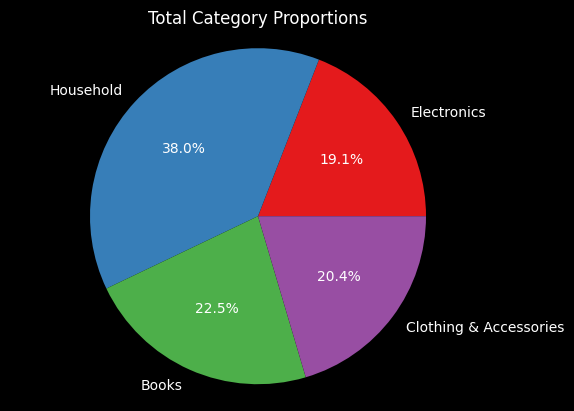

In [17]:
CAT_PERCENT = MY_DF.groupBy('CATEGORY').count().withColumn('percentage', (col('count') / sum('count').over(Window.partitionBy())) * 100)
CAT_PANDAS  = CAT_PERCENT.toPandas()

plt.style.use('dark_background')
plt.pie(CAT_PANDAS['percentage'], labels = CAT_PANDAS['CATEGORY'], autopct = '%1.1f%%', colors = sns.color_palette('Set1'))
plt.title('Total Category Proportions')
plt.axis('equal')
plt.show()

* `Household` **WordCloud**

  * Shows all the words associated with household items.

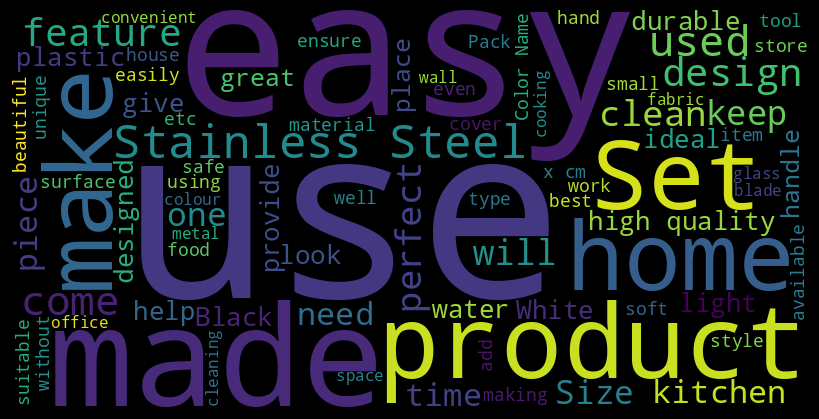

In [18]:
TXT = ' '.join(MY_DF.filter(MY_DF['CATEGORY'] == 'Household').select('PROD_DESC').toPandas()['PROD_DESC'].tolist())

plt.figure(figsize = (8, 4), facecolor = None)
plt.imshow(WordCloud(width = 800, height = 400, background_color = 'black', min_font_size = 10).generate(TXT))
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

* `Books` **WordCloud**

  * Shows all the words associated with books.

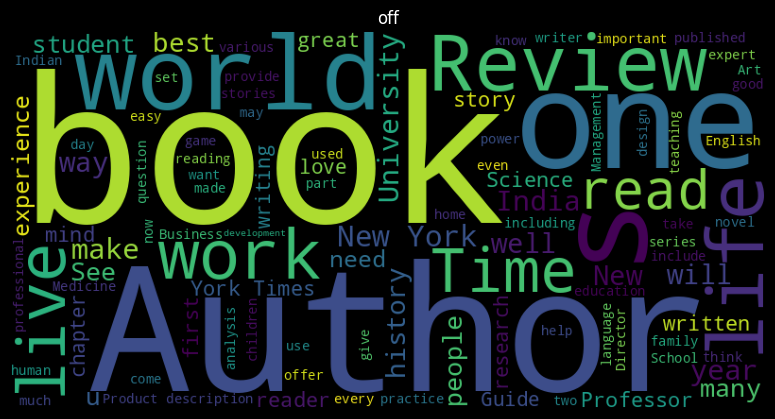

In [19]:
TXT = ' '.join(MY_DF.filter(MY_DF['CATEGORY'] == 'Books').select('PROD_DESC').toPandas()['PROD_DESC'].tolist())

plt.figure(figsize = (8, 4), facecolor = None)
plt.title('off')
plt.imshow(WordCloud(width = 800, height = 400, background_color = 'black', min_font_size = 10).generate(TXT))
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

* `Clothing & Accessories` **WordCloud**

  * Shows all the words associated with clothing and accessory items.

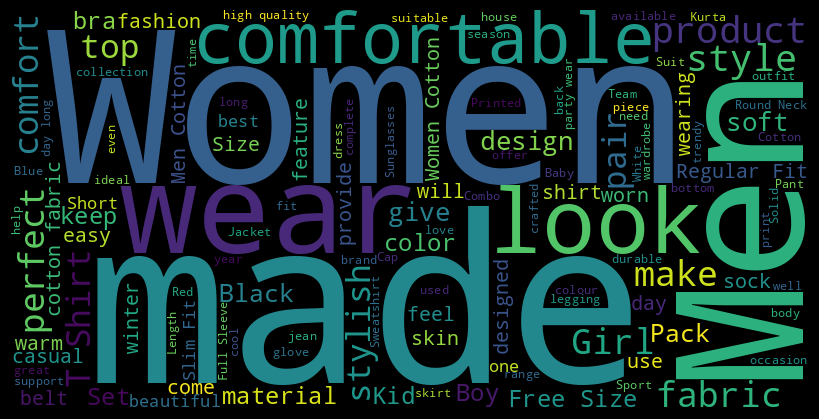

In [20]:
TXT = ' '.join(MY_DF.filter(MY_DF['CATEGORY'] == 'Clothing & Accessories').select('PROD_DESC').toPandas()['PROD_DESC'].tolist())

plt.figure(figsize = (8, 4), facecolor = None)
plt.imshow(WordCloud(width = 800, height = 400, background_color = 'black', min_font_size = 10).generate(TXT))
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

* `Electronics` **WordCloud**

  * Shows all the words associated with electronic devices.

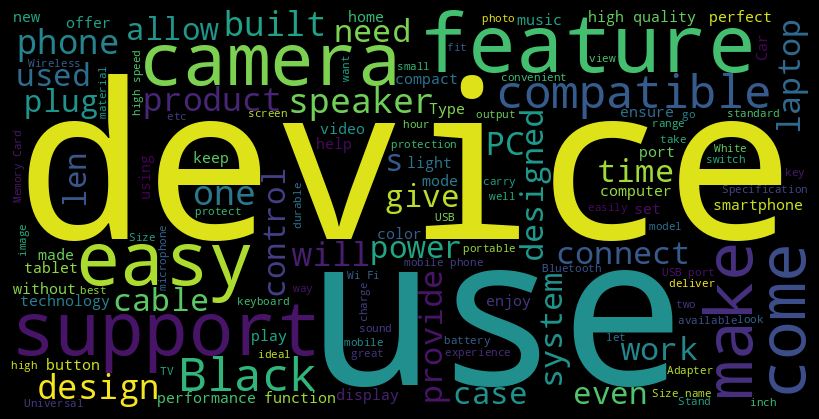

In [21]:
TXT = ' '.join(MY_DF.filter(MY_DF['CATEGORY'] == 'Electronics').select('PROD_DESC').toPandas()['PROD_DESC'].tolist())

plt.figure(figsize = (8, 4), facecolor = None)
plt.imshow(WordCloud(width = 800, height = 400, background_color = 'black', min_font_size = 10).generate(TXT))
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

###**5. Tokenization**

* Cleaning up our `PROD_DESC` textual data.
* The `CLEAN_UP_TEXT()` function does the following:

  * Remove any stop words and punctuation.
  * Tokenization, where each separate word in the review text is represented as an individual item.
  * Lemmatization, where each tokenized word is converted to its common base or dictionary form in order for the model to easily determine the meaning of the word within the context of the sentence the word is in or even the entire document.

In [22]:
BROADCAST = SPARK.sparkContext.broadcast(stopwords.words('english') + list(punctuation))

def CLEAN_UP_TEXT(TEXT):
  REMOVED         = BROADCAST.value
  TOKENIZED       = nltk.word_tokenize(TEXT)
  TOKEN_WORD      = [W for W in TOKENIZED if W.isalpha()]
  PROCESSED_TOKEN = [WordNetLemmatizer().lemmatize(W.lower()) for W in TOKEN_WORD if W not in REMOVED]
  CLEANED_TEXT    = re.sub('(\\b[A-Za-z] \\b|\\b [A-Za-z]\\b)', '', ' '.join(PROCESSED_TOKEN))
  return CLEANED_TEXT

MY_DF = MY_DF.withColumn('PROD_DESC', udf(CLEAN_UP_TEXT, StringType())(MY_DF['PROD_DESC']))

MY_DF.show()

+--------------------+---------+
|           PROD_DESC| CATEGORY|
+--------------------+---------+
|lotus herbal ecos...|Household|
|jaipurwood flora ...|Household|
|oyo baby waterpro...|Household|
|onion garlic stri...|Household|
|eerafashionicing ...|Household|
|decal creation sw...|Household|
|tied ribbon table...|Household|
|soft baby boy gir...|Household|
|elevanto premium ...|Household|
|imperial home col...|Household|
|fresh loom shaggy...|Household|
|elkca golden dama...|Household|
|freelance piece m...|Household|
|cello multimate p...|Household|
|meiyiu lashing ba...|Household|
|world need umbrel...|Household|
|trugood folding i...|Household|
|ajanta royal synt...|Household|
|swissmar nostalgi...|Household|
|buyerschowk paper...|Household|
+--------------------+---------+
only showing top 20 rows



###**6. Label Encoding**

* Numerically encode our `CATEGORY` labels using the `StringIndexer` module from *TensorFlow*.

In [23]:
INDEXER    = StringIndexer(inputCol = 'CATEGORY', outputCol = 'CATEGORY_CODE')
MY_DF      = INDEXER.fit(MY_DF).transform(MY_DF)
LABEL_DICT = MY_DF.select('CATEGORY', 'CATEGORY_CODE').distinct().toPandas().set_index('CATEGORY_CODE')['CATEGORY'].to_dict()
MY_DF      = MY_DF.drop('CATEGORY').withColumn('CATEGORY_CODE', MY_DF.CATEGORY_CODE.cast('int'))

MY_DF.show()

+--------------------+-------------+
|           PROD_DESC|CATEGORY_CODE|
+--------------------+-------------+
|lotus herbal ecos...|            0|
|jaipurwood flora ...|            0|
|oyo baby waterpro...|            0|
|onion garlic stri...|            0|
|eerafashionicing ...|            0|
|decal creation sw...|            0|
|tied ribbon table...|            0|
|soft baby boy gir...|            0|
|elevanto premium ...|            0|
|imperial home col...|            0|
|fresh loom shaggy...|            0|
|elkca golden dama...|            0|
|freelance piece m...|            0|
|cello multimate p...|            0|
|meiyiu lashing ba...|            0|
|world need umbrel...|            0|
|trugood folding i...|            0|
|ajanta royal synt...|            0|
|swissmar nostalgi...|            0|
|buyerschowk paper...|            0|
+--------------------+-------------+
only showing top 20 rows



* **Key-Value Category Codes**

In [24]:
LABEL_DICT

{3.0: 'Electronics',
 0.0: 'Household',
 2.0: 'Clothing & Accessories',
 1.0: 'Books'}

* **Check schema**

In [25]:
MY_DF.printSchema()

root
 |-- PROD_DESC: string (nullable = true)
 |-- CATEGORY_CODE: integer (nullable = true)



###**7. PySpark to Pandas Conversion**

* Below, is the final dataset which will be used to build our RNN model.
* The goal of our analysis is to classify a product in either one of the four categories (`Household`, `Books`, `Clothing & Accessories`,  `Electronics`) based on their description.

In [26]:
MY_DF = MY_DF.toPandas()

MY_DF.head(10)

,PROD_DESC,CATEGORY_CODE
0,lotus herbal ecostay kajal the formula give in...,0
1,jaipurwood flora solid wood multipurpose rocki...,0
2,oyo baby waterproof bed protector dry sheet na...,0
3,onion garlic string artificial vegetable the s...,0
4,eerafashionicing pompom lace border dress craf...,0
5,decal creation switch board sticker switch sti...,0
6,tied ribbon table top buddha water fountain ho...,0
7,soft baby boy girl dressing gown bath robe kid...,0
8,elevanto premium collection sleeve terry cotto...,0
9,imperial home collection duvet cotton blue whi...,0


* **Final Dataset Check**

In [27]:
MY_DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27803 entries, 0 to 27802
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   PROD_DESC      27803 non-null  object
 1   CATEGORY_CODE  27803 non-null  int32 
dtypes: int32(1), object(1)
memory usage: 325.9+ KB


###**8. Additional Data Formatting**

* **Tokenization and Sequencing**

  * The `Tokenizer()` object will be used to convert text data into numerical sequences.
  * The `fit_on_texts()` method will fit the Tokenizer object on the list containing product descriptions.
    * This step builds the vocabulary of the tokenizer by analyzing the frequency of each word in the text samples.
    * Each word is assigned a unique index (an integer value) based on its frequency.

In [28]:
TOKENIZER = Tokenizer()
TEXTS     = MY_DF['PROD_DESC'].to_list()

TOKENIZER.fit_on_texts(TEXTS)

* **Our Features**

  * The `texts_to_sequences()` module converts the list of product descriptions (`TEXTS`) into sequences of integers using the previously fitted `Tokenizer()` object.
    * Each word in a description is replaced with its corresponding index from the tokenizer's vocabulary.
  * the `pad_sequences()` class pads the sequences to a uniform length.

In [29]:
X = np.array(pad_sequences(TOKENIZER.texts_to_sequences(TEXTS), padding = 'post', truncating = 'post'), dtype = np.int32)

X

array([[ 8057,  5081, 25234, ...,     0,     0,     0],
       [16815,  7335,   316, ...,     0,     0,     0],
       [ 8300,   191,   426, ...,     0,     0,     0],
       ...,
       [ 3133,   206,  1197, ...,     0,     0,     0],
       [ 7858,   758,  1150, ...,     0,     0,     0],
       [ 7858,   122,    39, ...,     0,     0,     0]], dtype=int32)

* **The Targets**

In [30]:
y = np.array(MY_DF['CATEGORY_CODE'].to_list(), dtype = np.int32)

y

array([0, 0, 0, ..., 3, 3, 3], dtype=int32)

###**9. Train-Validation-Test Splits**


* **Training Data Portion**

* The `stratify` parameter ensures that our samples are fairly represented in our training data.

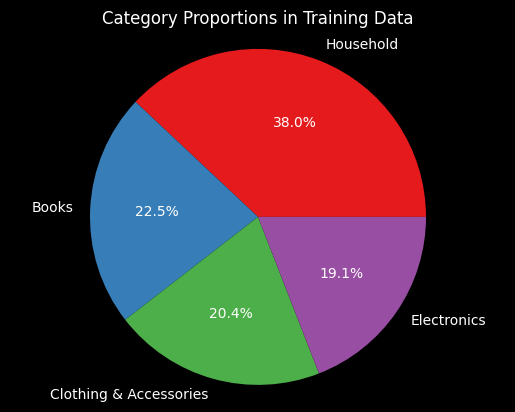

In [31]:
X_train, X_rest, y_train, y_rest = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)
UNIQUE, COUNTS                   = np.unique(y_train, return_counts = True)
LABELS                           = [LABEL_DICT[L] for L in UNIQUE]

plt.pie((COUNTS / len(y_train)) * 100, labels = LABELS, autopct = '%1.1f%%', colors = sns.color_palette('Set1'))
plt.title('Category Proportions in Training Data')
plt.axis('equal')
plt.show()

* **Validation and Testing Data Portions**

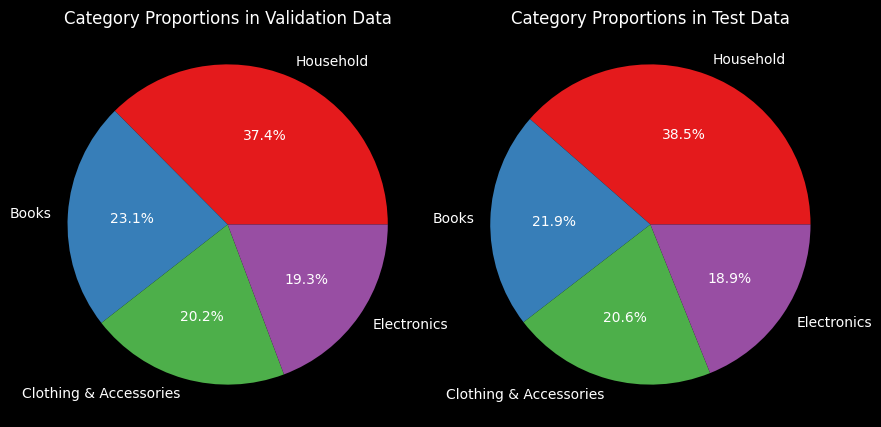

In [32]:
X_valid, X_test, y_valid, y_test = train_test_split(X_rest, y_rest, test_size = 0.5, random_state = 42)

UNIQUE_VALID, COUNTS_VALID = np.unique(y_valid, return_counts = True)
LABELS_VALID               = [LABEL_DICT[L] for L in UNIQUE_VALID]

UNIQUE_TEST, COUNTS_TEST   = np.unique(y_test, return_counts = True)
LABELS_TEST                = [LABEL_DICT[L] for L in UNIQUE_TEST]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
ax1.pie((COUNTS_VALID / len(y_valid)) * 100, labels = LABELS_VALID, autopct = '%1.1f%%', colors = sns.color_palette('Set1'))
ax1.set_title('Category Proportions in Validation Data')
ax1.axis('equal')

ax2.pie((COUNTS_TEST / len(y_test)) * 100, labels = LABELS_TEST, autopct = '%1.1f%%', colors = sns.color_palette('Set1'))
ax2.set_title('Category Proportions in Test Data')
ax2.axis('equal')

plt.show()

* **Our Data Split shapes**

  * I am using a 80:10:10 split on my data.

In [33]:
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape

((22242, 4511), (22242,), (2780, 4511), (2780,), (2781, 4511), (2781,))

###**10. Modelling**

* What is a Recurrent Neural Network?
 * a type of neural network designed to recognize patterns in sequences of data, such as text, speech or time-series data
 * Key components of an RNN:
    1. Input gate
      * Controls the flow of new information into the hidden state.
    2. Hidden state
      * Stores information from previous inputs, allowing the RNN to maintain context.
    3. Output gate
      * Generates the final output based on the hidden state.
    4. Recurrent connections
      * Feedback loops between layers, enabling the RNN to capture long-term dependencies.

  * RNNs are well-suited for tasks like:
    1. Language modeling and translation
    2. Speech recognition
    3. Time series forecasting
    4. Text classification and sentiment analysis
    5. Music and audio generation


* **LSTM Model Setup**

  * A LSTM model (a type of RNN) will be used to classify our products firstly, by learning the relationships between the words in the product descriptions and their respective categories.

    1. Text preprocessing
      * The product descriptions are first cleaned and tokenized, converting the text into numerical sequences that the LSTM can understand.

    2. LSTM layers
      * The LSTM layers process the sequences, capturing the context and meaning of the words.

    3. Dense layer
      * The final dense layer uses the learned information to predict the probability of the product belonging to each category.

    4. Output
      * The output is the category with the highest probability.

  * The model learns these relationships during the training process, where it adjusts its internal parameters to minimize the difference between its predictions and the actual categories.

In [34]:
LSTM_MODEL  = Sequential()
INPUT_DIMS  = len(TOKENIZER.word_index) + 1
OUTPUT_DIMS = 128
N_NODES     = 64
DROP_OUT    = 0.2
OUTPUTS     = len(np.unique(y))

LSTM_MODEL.add(Embedding(input_dim = INPUT_DIMS, output_dim = OUTPUT_DIMS))
LSTM_MODEL.add(SpatialDropout1D(DROP_OUT))
LSTM_MODEL.add(Bidirectional(LSTM(N_NODES, return_sequences = False)))
LSTM_MODEL.add(Dense(OUTPUTS, activation = 'softmax'))
LSTM_MODEL.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

* **Model Training**

  * I have set `epochs` to 2.
      * An epoch is one complete pass through the entire training dataset.

  * The `EarlyStopping` instance will keep an eye on  the training loss and will stop the training process if the loss doesn't improve for two (`patience` is set to two) consecutive epochs
    * This prevents overfitting and saves time.
  * **NOTE:** This model was trained using the T4 GPU from Google Compute Engine backend, training time and results may vary based on the specs of the system running this notebook.

In [35]:
NUM_EPOCHS = 2
EARLY_STOP = EarlyStopping(monitor = 'loss', patience = 2)
TRAIN      = LSTM_MODEL.fit(X_train, y_train, epochs = NUM_EPOCHS, callbacks = [EARLY_STOP])

Epoch 1/2
696/696 ━━━━━━━━━━━━━━━━━━━━ 176s 244ms/step - accuracy: 0.7990 - loss: 0.5369
Epoch 2/2
696/696 ━━━━━━━━━━━━━━━━━━━━ 211s 263ms/step - accuracy: 0.9771 - loss: 0.0847


* **Training Log**

  * The model's accuracy increasing from approximately 80% to 97%.

  * The sparse categorical cross entropy loss decreased from 0.54 to 0.08.

  * This means the model is learning and improved its performance.

###**11. Evaluation**

* **Confusion Matrices**

  * The confusion matrices our the model's performance on the validation and test sets.
  * Each row of the matrix represents the actual class, while each column represents the predicted class.

    * Correct predictions
      * The diagonal elements of the matrices show the number of correct predictions for each class.
      * For example, in the validation set, our model correctly predicted 996 instances of `Household`, 611 instances of `Books`, 545 instances of `Clothing & Accessories` and 497 instances of `Electronics`.

    * Incorrect predictions
      * The off-diagonal elements show the number of incorrect predictions.
      * For example, in the test set, our model incorrectly predicted 12 instances of `Household` as `Electronics`.

  * Overall performance
    * Both confusion matrices show that our model is performing well, with most predictions being correct.
    * There are some misclassifications, but they are relatively few compared to the correct predictions.

87/87 ━━━━━━━━━━━━━━━━━━━━ 11s 122ms/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 9s 99ms/step


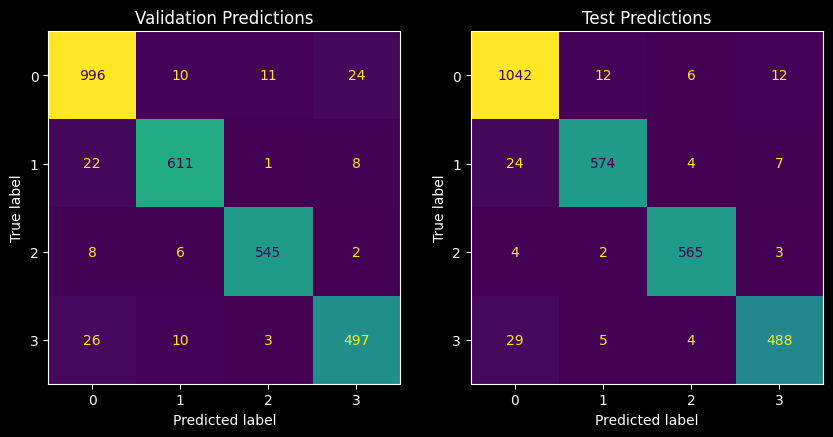

In [37]:
Y_PRED_VALID    = np.argmax(LSTM_MODEL.predict(X_valid), axis = 1)
Y_PRED_TEST     = np.argmax(LSTM_MODEL.predict(X_test), axis = 1)
DISP_VALID      = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_valid, Y_PRED_VALID))
DISP_TEST       = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, Y_PRED_TEST))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))

DISP_VALID.plot(ax = ax1, colorbar = False)
ax1.set_title('Validation Predictions')

DISP_TEST.plot(ax = ax2, colorbar = False)
ax2.set_title('Test Predictions')

plt.show()

* **Classification Metrics**

  1. `precision`
    * Measures the accuracy of positive predictions.
    * For example, in the validation set, the model has a precision of `0.95` for `Household`, meaning 95% of the instances predicted as Household were actually `Household`.

  2. `recall`
    * Measures the ability of the model to identify all positive instances
    * For example, in the test set, the model has a recall of `0.97` for `Books`, meaning it correctly identified 97% of all actual `Books` instances.

  3. `f1-score`
    * The harmonic mean of precision and recall, providing a balanced measure of the model's performance.

  4. `support`
    * The number of instances of each class in the dataset.

  5. `accuracy`
    * The overall proportion of correctly classified instances.

  6. `macro avg`
    * The average of the metrics across all classes, giving equal weight to each class.

  7. `weighted avg`
    * The average of the metrics across all classes, weighted by the number of instances in each class.



In [38]:
print(classification_report(y_valid, Y_PRED_VALID))

              precision    recall  f1-score   support

           0       0.95      0.96      0.95      1041
           1       0.96      0.95      0.96       642
           2       0.97      0.97      0.97       561
           3       0.94      0.93      0.93       536

    accuracy                           0.95      2780
   macro avg       0.95      0.95      0.95      2780
weighted avg       0.95      0.95      0.95      2780



In [39]:
print(classification_report(y_test, Y_PRED_TEST))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96      1072
           1       0.97      0.94      0.96       609
           2       0.98      0.98      0.98       574
           3       0.96      0.93      0.94       526

    accuracy                           0.96      2781
   macro avg       0.96      0.96      0.96      2781
weighted avg       0.96      0.96      0.96      2781



* **Final Judgement**

  * The reports have shown that our model is performing well with high precision, recall and F1-scores for each of our target categories.
  * The accuracy is also high, indicating that our model is correctly classifying most of the samples in our dataset.
  * There are some minor differences in the performance of our model between the validation and test sets, but they are relatively small, suggesting that the model is generalizing well to unseen data.

###**12. PySpark End**

* End our *Spark* session.

In [40]:
SPARK.stop()